In [1]:
#Disable warnings
import warnings
warnings.filterwarnings('ignore')

#basics
import numpy as np
import pandas as pd

#viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind')

# Scaler import
from sklearn.preprocessing import MinMaxScaler

# DBSCAN import
from sklearn.cluster import DBSCAN

#Import custom libraries
import wrangle as w 
import prepare as p

In [2]:
#get initial data
df = w.get_curriculum_data()

Returning saved csv files.


### Question 1: Which lesson appears to attract the most traffic consistently across cohorts (per program)?

#### A: Out of the top ten most requested pages the javascript-i lesson looks to be the most commonly requested page

Note: '/' and 'search...' pages were ignored as they are expected to represent the curriculum home page and search functionality

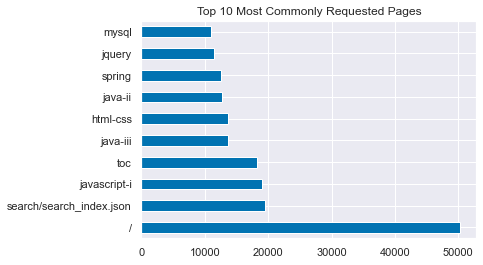

In [3]:
df.path.value_counts().head(10).plot.barh(
    title='Top 10 Most Commonly Requested Pages');

In [4]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )
#Look at the top lessons accessed
path_df = value_counts_and_frequencies(df.path)
path_df.head(10)

,count,proba
/,50313,0.055889
search/search_index.json,19519,0.021682
javascript-i,18983,0.021087
toc,18297,0.020325
java-iii,13733,0.015255
html-css,13635,0.015146
java-ii,12685,0.014091
spring,12524,0.013912
jquery,11525,0.012802
mysql,11033,0.012256


### Question 2: Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over?

#### A: The Classification module in the curriculum was accessed significantly more by Darden compared to the other cohorts.

For this, we looked at the cohorts that accessed the curriculum most.

<AxesSubplot:ylabel='name'>

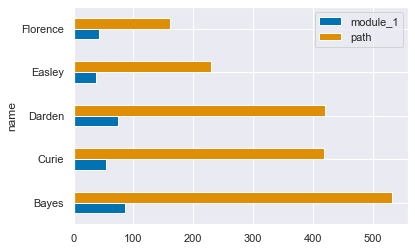

In [5]:
#Let's take a look at user lesson counts
lesson_counts_by_cohort = df.groupby(['name'])['date','name','path'].nunique()
#Let's take a look at user lesson counts by path
lesson_counts_by_path = df.groupby(['path'])['date','name'].nunique()

#Create an initial lesson category to group paths by
df['module_1'] = df.path.str.split('/').str[0]
df['module_2'] = df.path.str.split('/').str[1]
# Let's create a subset of data science students to compare lessons by cohort
ds_cohorts = df[(df['program_name'] == 'data_science')  & (df['name'] != 'staff')]
ds_lesson_counts_by_path = ds_cohorts.groupby(['name'])['module_1','path'].nunique()
ds_lesson_counts_by_path.plot.barh()

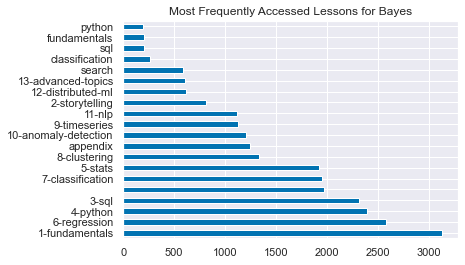

In [6]:
ds_bayes = ds_cohorts[ds_cohorts['name']== 'Bayes']
dsb = ds_bayes.module_1.value_counts()
dsb.head(20).plot.barh()
plt.title ("Most Frequently Accessed Lessons for Bayes");

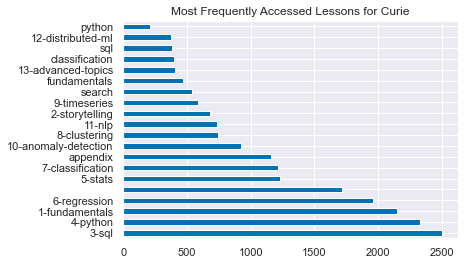

In [7]:
ds_curie = ds_cohorts[ds_cohorts['name']== 'Curie']
dsc = ds_curie.module_1.value_counts()
dsc.head(20).plot.barh()
plt.title ("Most Frequently Accessed Lessons for Curie");

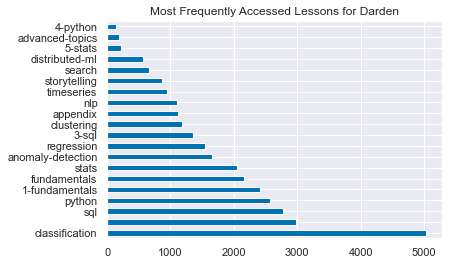

In [8]:
ds_darden = ds_cohorts[ds_cohorts['name']== 'Darden']
dsd = ds_darden.module_1.value_counts()
dsd.head(20).plot.barh()
plt.title ("Most Frequently Accessed Lessons for Darden");

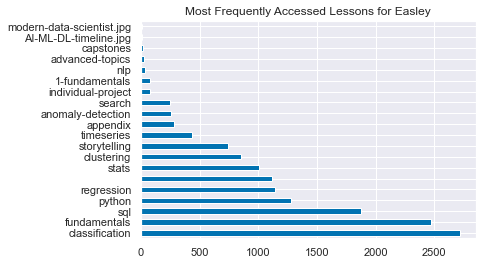

In [9]:
ds_easley = ds_cohorts[ds_cohorts['name']== 'Easley']
dse = ds_easley.module_1.value_counts()
dse.head(20).plot.barh()
plt.title ("Most Frequently Accessed Lessons for Easley");

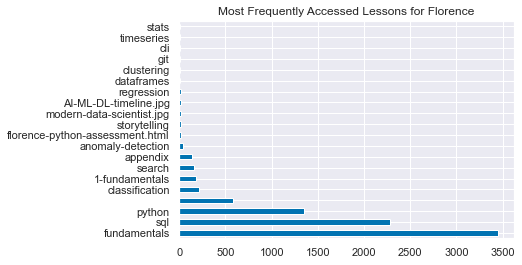

In [10]:
ds_florence = ds_cohorts[ds_cohorts['name']== 'Florence']
dsf = ds_florence.module_1.value_counts()
dsf.head(20).plot.barh()
plt.title ("Most Frequently Accessed Lessons for Florence");

### Question 3:  Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

#### A : The student in the who were in the bottom 25% of number of pings had an average of accessing the curriculum 102 days before the end of thier cohort, and 75% had their last access date 22 days before the end of the cohort.  Therefore it seems likely that the students had left the program without graduating.

- There are in the following cohorts : Sequoia, Teddy, Ulysses, Voyageurs, Yosemite, Xanadu, Zion, Andromeda, 'Betelgeuse', 'Ceres', 'Bayes', 'Deimos', Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede', 'Hyperion', Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna', 'Easley', 'Marco', 'Neptune', 'Florence', 'Oberon'
- These are all full stack java and data science cohorts ending inbetween 2018 to 2021
- In looking at the difference between the students last ping and the end date for the cohort, just over half of these students made their last ping ~4 weeks before the end of the cohort, indicating that they may have left.

The graph below shows select cohorts with accesses from the bottom 25% of users hued in orange.  As can be seen, users tended to stop accessing the curriculum before the end of the cohort.

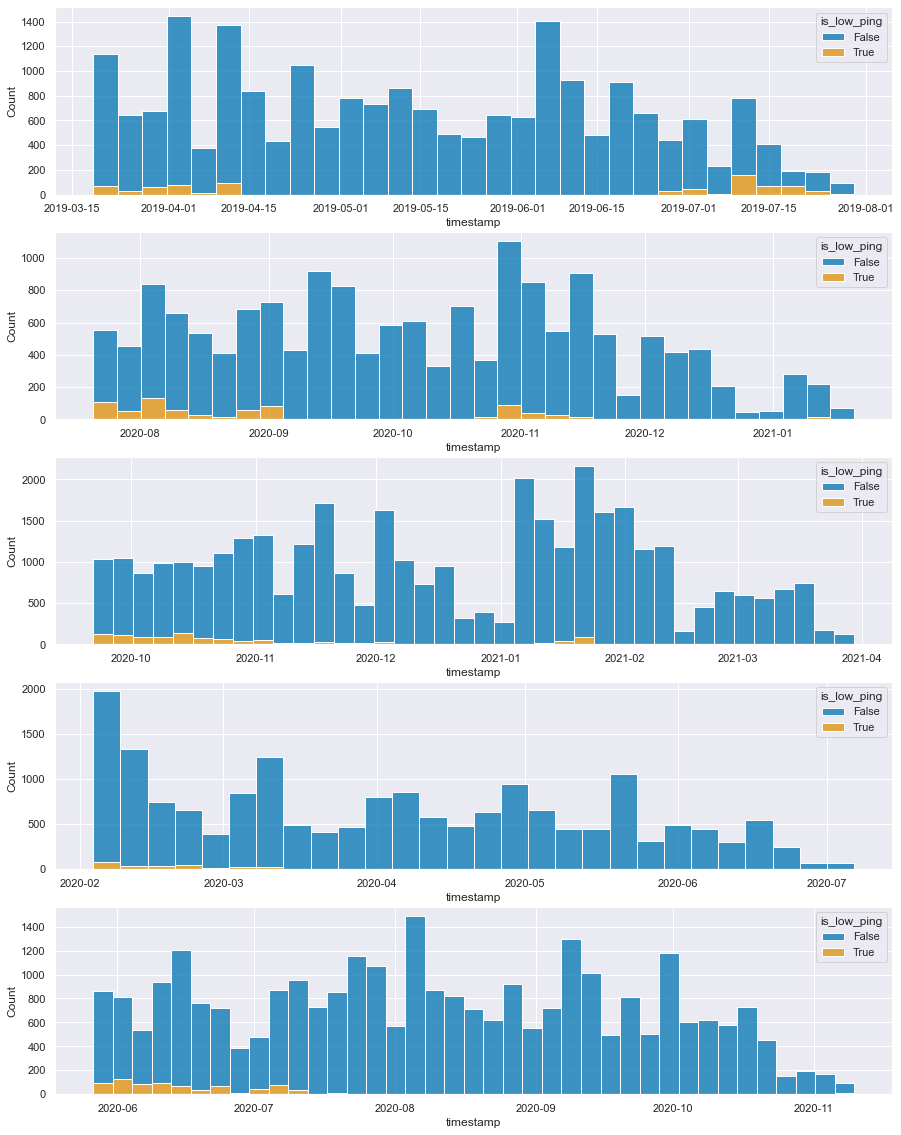

In [11]:
df2 = w.prepare_datetime_col(df)
def question_three(df2):
    df=df2.copy()
    df['start_date'] = pd.to_datetime(df['start_date'])
    df['end_date'] = pd.to_datetime(df['end_date'])
    df = df[~(df.name=='Staff')]
    df = df[(df.timestamp > df.start_date) & (df.timestamp < df.end_date)]
    usercounts = pd.DataFrame(df[['user_id']].value_counts()).rename(columns={0:'count'})
    low_ping_users = usercounts[usercounts['count'] <= df.user_id.value_counts().quantile(0.25)].reset_index()['user_id']
    df['is_low_ping'] = df['user_id'].isin(low_ping_users)
    low_ping_cohorts = df.groupby('name').is_low_ping.count().index.tolist()
    fig, axes = plt.subplots(5,1, figsize = (15,20))
    sns.histplot(data = df[df['name']=='Andromeda'], x='timestamp', hue='is_low_ping', multiple='stack', ax=axes[0])
    sns.histplot(data = df[df['name']=='Bash'], x='timestamp', hue='is_low_ping', multiple='stack',  ax=axes[1])
    sns.histplot(data = df[df['name']=='Jupiter'], x='timestamp', hue='is_low_ping', multiple='stack',  ax=axes[2])
    sns.histplot(data = df[df['name']=='Curie'], x='timestamp', hue='is_low_ping', multiple='stack',  ax=axes[3])
    sns.histplot(data = df[df['name']=='Hyperion'], x='timestamp', hue='is_low_ping', multiple='stack', ax=axes[4])
    plt.show()

question_three(df)

### Question 4:  Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

#### A:  There is evidence of webscraping.  For example, ip `216.1.153.162` moves through a lot of pages within seconds.  There are a series of user_id that are not associated with any cohort; these could be suspicious-- particularly since some of them seem to be on the wifi.  It could be the case that they could be guests using the network, but there are more nefarious interpretations of this.

- the following user_id are not associated with a cohort : `48,  54,  58,  59,  61,  62,  63,  73,  74,  78,  79,  86,  88, 89, 100, 103, 111, 137, 166, 176, 213, 247, 317, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 372, 375, 403, 406, 429, 544,  64, 713, 714, 715, 716, 717, 718, 663, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 346, 731, 736, 644, 744, 782, 810, 814, 815`
    - some of these are associated only with one ip

- `97.105.19.58` and `97.105.19.61` are likely wifi, but because of the significant traffic and users, it might be worth double checking what these ip addresses are.

The below list of user_id that do not have an associated cohort. These would be worth investigating.

In [12]:
def question_four(df):
    return df[df.program_name == 'unknown_program'].user_id.unique()

question_four(df)

array([ 48,  54,  58,  59,  61,  62,  63,  73,  74,  78,  79,  86,  88,
        89, 100, 103, 111, 137, 166, 176, 213, 247, 317, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 372, 375, 403, 406, 429, 544,  64, 713,
       714, 715, 716, 717, 718, 663, 719, 720, 721, 722, 723, 724, 725,
       726, 727, 728, 729, 346, 731, 736, 644, 744, 782, 810, 814, 815])

### Question 5 - At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

Given the timelines mentioned, I was unable to concretely define certain curriculums by program.  This is likely mostly due to treating each program seperately instead of aggregating by full_stack_php, full_stack_java and front_end.  Treating 2020+ data as 'clean', I was able to identify times at which programs had cross-curriculum activity. However, the timelines in the plot do not seem to match with this question, as most of 2019 contained cross-curriculum activity.  Looking into it a little more, it seems that all the registered activity is between full_stack_php and full_stack_java.


In [13]:
def question5_fullpaths(df):
    #do some more wrangling
    df5 = w.q5_wrangle(df)
    #Get 2020 and later site visits 
    #represents 'clean' data - when students couldn't access each other's curriculum
    df5_rest = df5[df5.date > '2019-12-31']
    
    ############## Section may change if I decide to use the whole path
    #create 'root' paths dataframe - just the first part of the url (after the domain)
    all_paths = pd.DataFrame(df5_rest.path.unique()).rename(columns={0:'path'}) #261
    #loop over each program
    for cnt,p in enumerate(df5.program_name.unique()):
        #create new column name
        col_name = str(p)
        #make subset of root paths accessed by this program
        prog_paths = df5_rest[df5_rest.program_name == p].path
        #create 0/1 column to see if that path was accessed by this program
        all_paths[col_name] = all_paths.path.isin(prog_paths).astype(int)

    #Now aggregate and find columns that only one program ever accessed
    all_paths['only_one'] = (1 == all_paths.loc[:,'full_stack_php':'data_science'].sum(axis=1))
    
    #create dataframe of root paths that only one program has access to
    all_paths_rest = all_paths[all_paths.only_one]
    ##############
    
    ##### Now create dataframe of cross_access logs ####
    cross_access = pd.DataFrame()
    #loop over each program
    for cnt, p in enumerate(df5.program_name.unique()):
        #get entries that don't include that program
        df_not_p = df5[df5.program_name != p]
        #now add any inappropriate access times
        #if the path of any other program, is in that exclusive program's url, then add the line
        subset = df_not_p[df_not_p.path.isin(all_paths_rest[all_paths_rest[p] == 1].path)]
        cross_access = pd.concat([cross_access,subset])

    cross_access.drop_duplicates(inplace=True)
    ##############
    
    ## Plot timeline of 'inappropriate' access
    plt.figure(figsize=(12,6))
    sns.histplot(data=cross_access,x='date',binwidth=14)
    plt.title('Subset of Cross-Curriculum Access Activity',size=14);
    plt.ylabel('Site Visits');
    plt.xlabel('Date');
    return None    

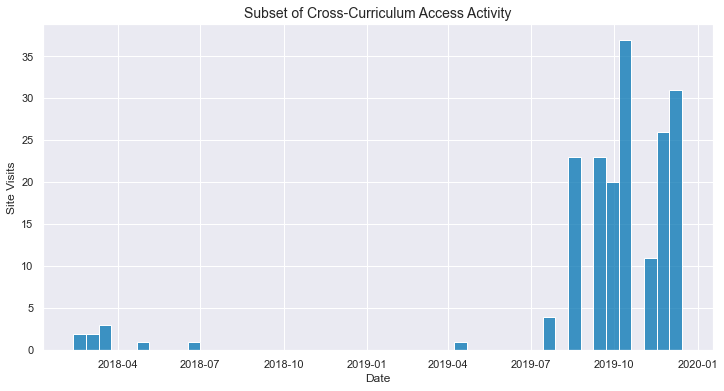

In [14]:
question5_fullpaths(df)

### Question 6 - What topics are grads continuing to reference after graduation and into their jobs (for each program)?

- Full stack java and php cohorts accessed these classes most after graduation:
  - Javascript i
  - Html - css
  - spring
- Data Science cohorts accessed these classes most after graduation:
  - Intro to Data Science
    - Note: this was aggregated across multiple naming conventions - likely due to a change in website structure
  - MySQL Overview
  - Classification Overview

*With a greater understanding of the site layout and how the site structure changed in the past, further insights could be provided*

In [15]:
def question6(df):
    #do some more wrangling
    df6 = w.q6_wrangle(df)
    #Plot most popular websites:
    plt.figure(figsize=(10,25))
    colors = sns.color_palette('colorblind').as_hex()
    # length = len(df.program_name.nunique())
    #loop over each program
    cnt=1
    for p in df6.program_name.unique():
        if p == 'front_end': continue
        #get subset of site visits for this program
        df_prog = df6[df6.program_name == p]
        #get top visits
        df_prog_top = pd.DataFrame(df_prog.path.value_counts()).rename(columns={'path':'count'})
        df_prog_top['path'] = df_prog_top.index
        #plot top 10 visits per program
        plt.subplot(3,1,cnt)
        plt.title(f'Top 10 site visits for {p}',size=14);
        sns.barplot(y = 'path', x = 'count',data= df_prog_top.head(10), orient = 'h',color=colors[cnt]);
        plt.xlabel('Number of post-graduation site visits');
        cnt+=1
    return None

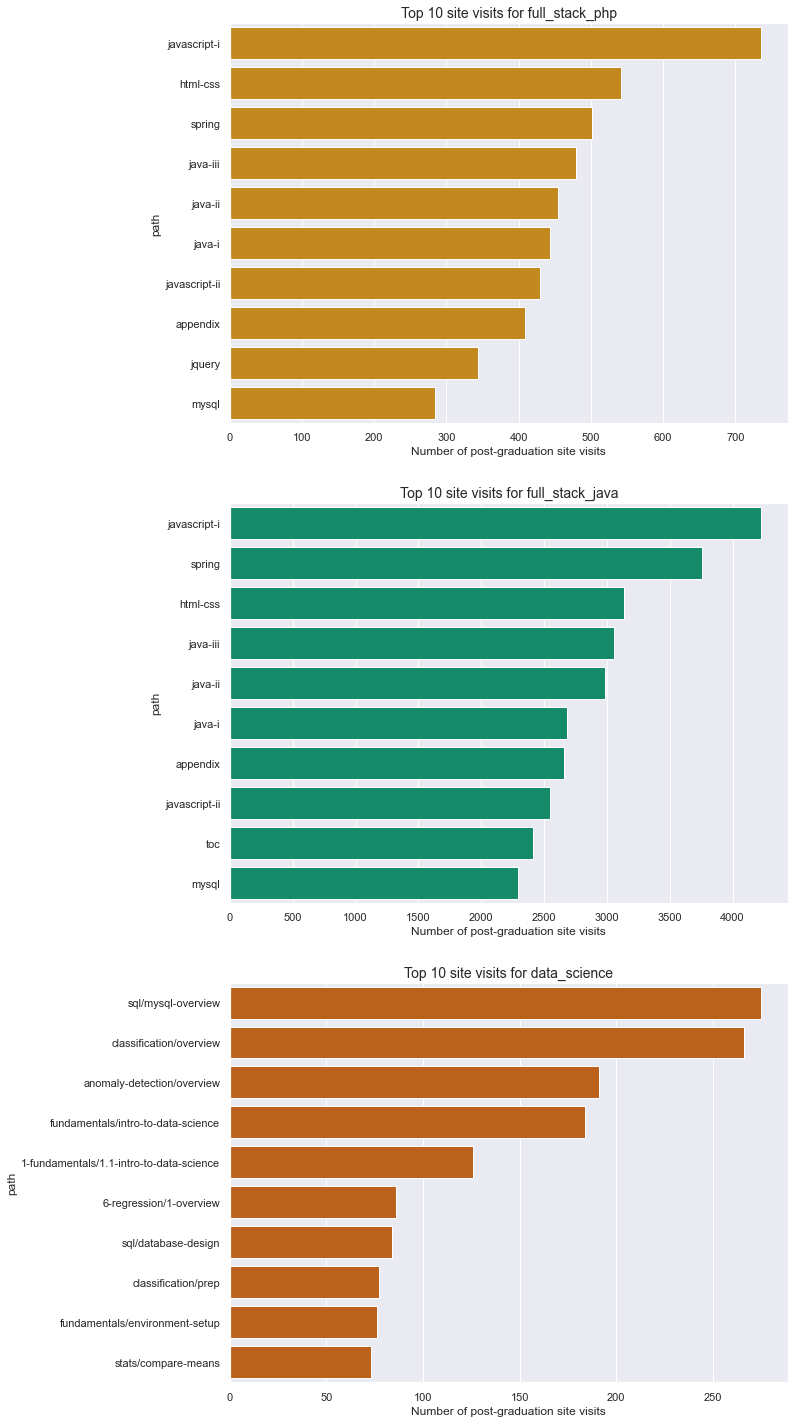

In [16]:
question6(df)

### Question 7: Which lessons are least accessed?

**How data was prepped and filtered:**
- Programs chosen: Data Science & web development
- Type of data: Only those that had an end date in there file.
- Collumns used: "Start" collumn that was created by copying and splitting "path" column and only grabing             the first part of the string to be able to use that as lesson type.  
- Any data that had less then 10 views was removed for the purpose of sticking to the regular lessons vs. 
    random links
    
**Least viewed lessons in Data Science & Web Development:**:
- Pandas overview
- objects
- navigating the file system
- clasification acquiredata
- file paths darden python assement
- inspect
- bom and dom
- project planning and explore 
- open data
- excel shortcuts
- kmeans2

#### Least viewed lessons in Data Science
- Advance topics
- individual projects
- Capstone
- acquire
- working with time series

#### Least viwed lessons in web development:
- Data Acquisition
- Sessions and Cookies
- Capstone Workbook
- Import Excel
- Decision Tree set up


In [17]:
def berto_prep(old_df):
    df = old_df.copy()
    # replace nan values
    df.path = df.path.fillna('/')
    # create new columns with the Start and end of the endpoints
    df[['start', 'end']] = df.path.str.split(pat='/', n=1, expand=True)
    # remove pages that are not part of curriculum
    df = df[df.end.str.contains('jpeg') != True]
    df = df[df.end.str.contains('json') != True]
    df = df[df.end.str.contains('jpg') != True]
    df = df[df.end.str.contains('appendix') != True]
    df = df[df.end.str.contains('Appendix') != True]
    df = df[df.end != '/']
    df = df[df.end != 'toc']
    # removing numbers or special characters from start column 
    df.start = df.start.str.lstrip('0123456789.-')
    #creating a new column
    df['program_id'] = df['program_name']
    df = df.dropna(how='all')
    # create column for program names
    df.loc[df["program_id"] == "unknown_program", "program_id"] = 0
    df.loc[df["program_id"] == "full_stack_java", "program_id"] = 1
    df.loc[df["program_id"] == "front_end", "program_id"] = 1
    df.loc[df["program_id"] == "full_stack_php", "program_id"] = 1
    df.loc[df["program_id"] == "data_science", "program_id"] = 2
    return df

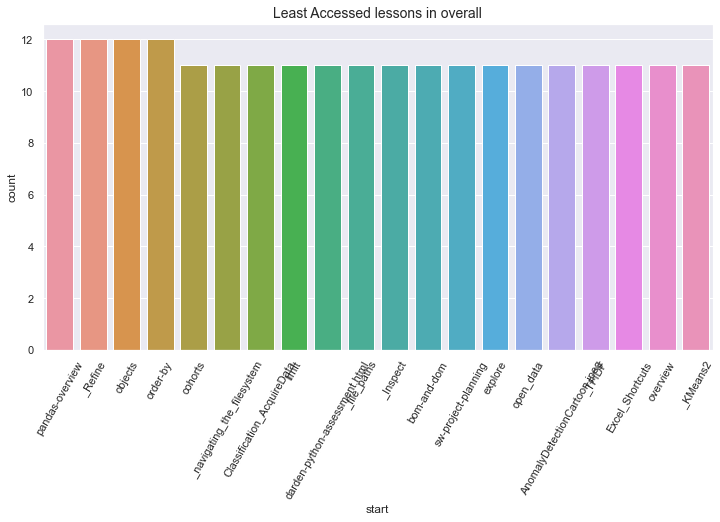

In [20]:
def lessons_least_visited_in_all_data(df):
    df = berto_prep(df)
    # check top pages for data science
    everything = df[(df.program_id == 1) | (df.program_id == 2) & (df.end_date)].start.value_counts(ascending=False).to_frame()
    # reset index
    everything.reset_index(inplace=True)
    # rename columns
    everything.columns = ('start', 'count')
    # check the topics that have less than 10 counts
    everything[everything['count'] < 10]
    # remove lower counts from dataframe
    everything = everything[everything['count'] > 10]
    # get least accessed topics for data science
    least_lessons_accessed_everything = everything.tail(20)
    # plot data science least accessed
    plt.figure(figsize=(12,6))
    sns.barplot(data=least_lessons_accessed_everything, x='start', y='count')
    plt.title('Least Accessed lessons in overall',size=14)
    plt.xticks(rotation=60);
    
lessons_least_visited_in_all_data(df)

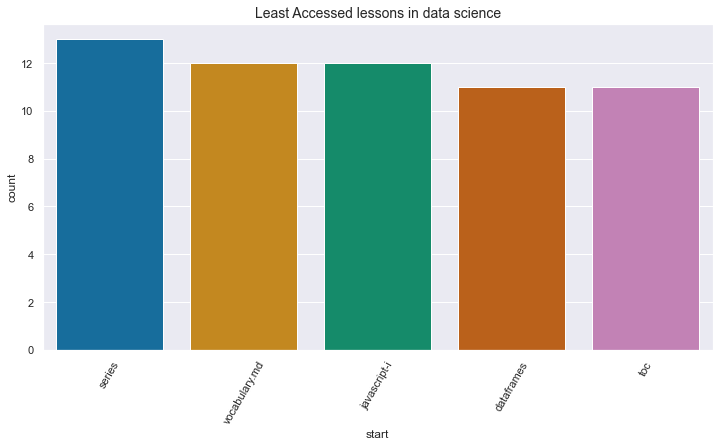

In [24]:
 def lessons_least_visited_in_data_science(df):
    df = berto_prep(df)
    # check top pages for data science
    ds = df[(df.program_id == 2) & (df.end_date)].start.value_counts(ascending=False).to_frame()
    # reset index
    ds.reset_index(inplace=True)
    # rename columns
    ds.columns = ('start', 'count')
    # check the topics that have less than 10 counts
    ds[ds['count'] < 10]
    # remove lower counts from dataframe
    ds = ds[ds['count'] > 10]
    # get least accessed topics for data science
    least_lessons_accessed_ds = ds.tail(5)
    # get least accessed topics for data science
    # plot data science least accessed
    plt.figure(figsize=(12,6))
    sns.barplot(data=least_lessons_accessed_ds, x='start', y='count')
    plt.title('Least Accessed lessons in data science',size=14)
    plt.xticks(rotation=60);
    
lessons_least_visited_in_data_science(df)

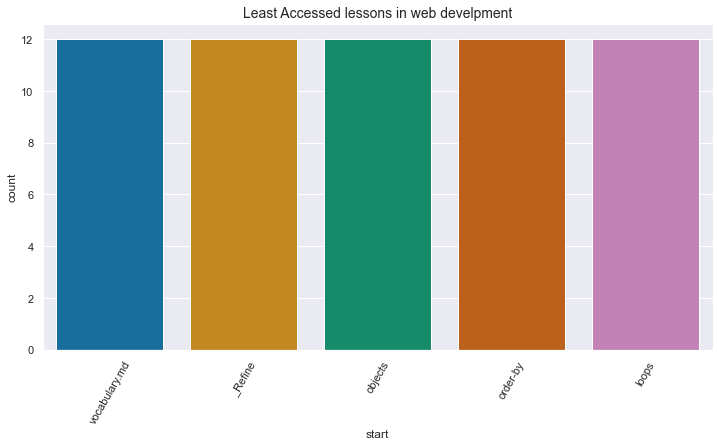

In [25]:
def lessons_least_visited_in_web_development(df):
    df = berto_prep(df)
    # check top pages for web development
    wd = df[(df.program_id == 1) & (df.end_date)].start.value_counts(ascending=False).to_frame()
    # reset index
    wd.reset_index(inplace=True)
    # rename columns
    wd.columns = ('start', 'count')
    # remove lower counts from dataframe
    wd = wd[wd['count'] > 11]
    # get least accessed topics for data science
    least_lessons_accessed_wd = wd.tail(5)
    # plot data science least accessed
    plt.figure(figsize=(12,6))
    sns.barplot(data=least_lessons_accessed_wd, x='start', y='count')
    plt.title('Least Accessed lessons in web develpment',size=14)
    plt.xticks(rotation=60);
    
lessons_least_visited_in_web_development(df)